# Imports

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import phoebe
from phoebe import u

matplotlib.rcParams['figure.figsize'] = (16, 6)
plt.style.use('science')

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
importlib.reload(gen_utils)

logger = phoebe.logger(clevel='WARNING')

# Load Bundle

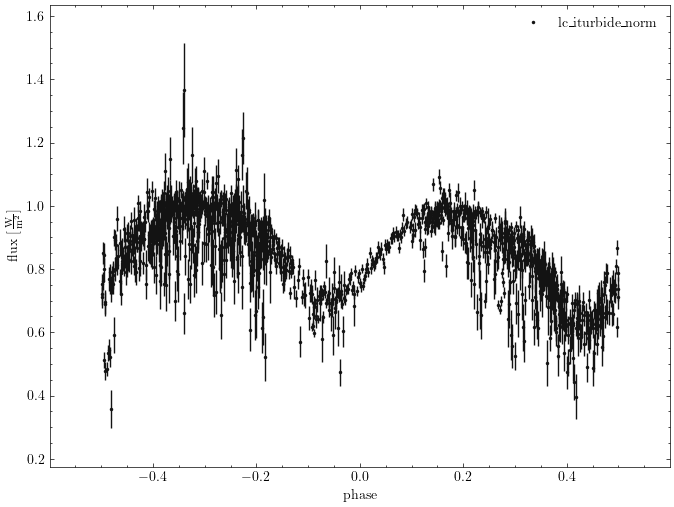

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [16]:
# b = phoebe.load("./bundle-saves/manual-periodogram")

# b = phoebe.load("./bundle-saves/clean-data/manual-periodogram")

# b = phoebe.load("./bundle-saves/aviles-data/manual-periodogram")
# b = phoebe.load("./bundle-saves/comp-LID3/manual-periodogram", import_from_newer=True)
# b = phoebe.load("../bundle-saves/iturbide-gaia-ztf")
# b = phoebe.load("../bundle-saves/relative-normalized/iturbide-gaia-ztf")
# gen_utils.resetAtmosphere(b)

b = gen_utils.loadBundle(bundleName="manual-periodogram", subfolder="detached")

IS_CONTACT = 'contact_envelope' in b.components

b.plot(x='phase', dataset='lc_iturbide_norm', show=True, legend=True, marker='.', s=0.008)
# b.plot(x='phase', dataset='lc_iturbide_raw', show=True, legend=True, marker='.')

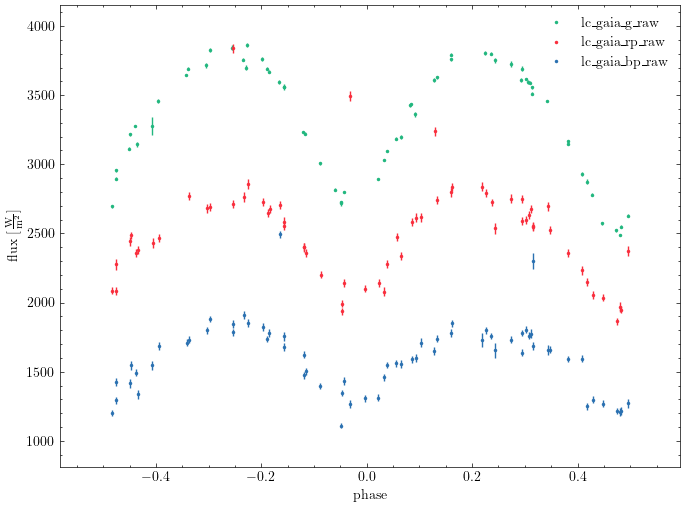

(<autofig.figure.Figure | 1 axes | 3 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [17]:
# normGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'norm' in d]
rawGaiaDatasets = [d for d in b.datasets if 'gaia' in d and 'raw' in d]

# b.plot(x='phase', dataset=normGaiaDatasets, color=gen_utils.GAIA_NORM_PLOT_COLORS, show=True, legend=True, marker='.', s=0.015)
b.plot(x='phase', dataset=rawGaiaDatasets, color=gen_utils.GAIA_RAW_PLOT_COLORS, show=True, legend=True, marker='.', s=0.008)

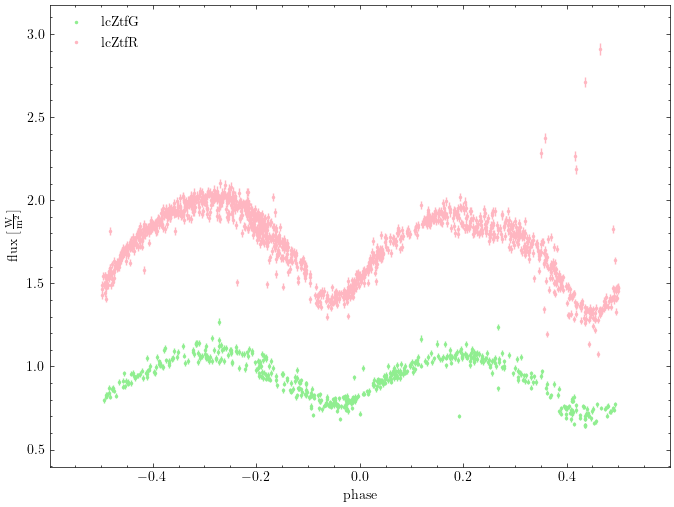

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [18]:
ztfDatasets = [d for d in b.datasets if 'Ztf' in d]

b.plot(x='phase', dataset=ztfDatasets, color=gen_utils.ZTF_PLOT_COLORS, show=True, legend=True, marker='.', s=0.008)

# Helper Functions

In [19]:
# plotRawDatasetsGroups = [['lc_iturbide_raw'], ['lc_iturbide_aviles_raw'], rawGaiaDatasets, ztfDatasets]

def printChi2(b: phoebe.Bundle, model: str):
	print(f"{model} chi2", "===================================================", sep='\n')

	#region Iturbide
	try:
		print('\t', "Iturbide -", np.sum(b.calculate_chi2(model=model, dataset='lc_iturbide_norm')))
	except: pass
	#endregion

	#region Gaia
	try:
		print('\t', "Gaia -", np.sum(b.calculate_chi2(model=model, dataset=rawGaiaDatasets)))
	except: pass

	try:
		for gd in rawGaiaDatasets:
			print('\t\t', gd, "-", np.sum(b.calculate_chi2(model=model, dataset=gd)))
	except: pass
	#endregion

	#region ZTF
	try:
		print('\t', "ZTF -", np.sum(b.calculate_chi2(model=model, dataset=ztfDatasets)))
	except: pass

	try:
		for zd in ztfDatasets:
			print('\t\t', zd, "-", np.sum(b.calculate_chi2(model=model, dataset=zd)))
	except: pass
	#endregion

def printAllModelsChi2(b: phoebe.Bundle):
	for m in b.models:
		printChi2(b, m)

# Default forward models

In [20]:
# EBAI KNN values all seem to affect relative values
    # setting to dataset-scaled to see if at least general shape of model is correct
    # might also help with getting a good trend out of residuals when adopting estimator solutions
b.set_value_all(qualifier='pblum_mode', value='dataset-scaled')

In [21]:
gen_utils.avoidAtmosphereErrors(b) # parameters out of bounds by default when using CK2004 atmospheres, temporarily switching over to black body
b.set_value_all(qualifier='enabled', value=True)
b.run_compute(model='default_model', overwrite=True)

Thu, 06 Jun 2024 01:56 UNIVERSE     WARNING target_volume of 0.22959922447470382 slightly over critical value, likely due to numerics: setting to critical value of 0.2295992244747038
100%|██████████| 3194/3194 [01:40<00:00, 31.93it/s]


<ParameterSet: 181 parameters | kinds: mesh, lc>

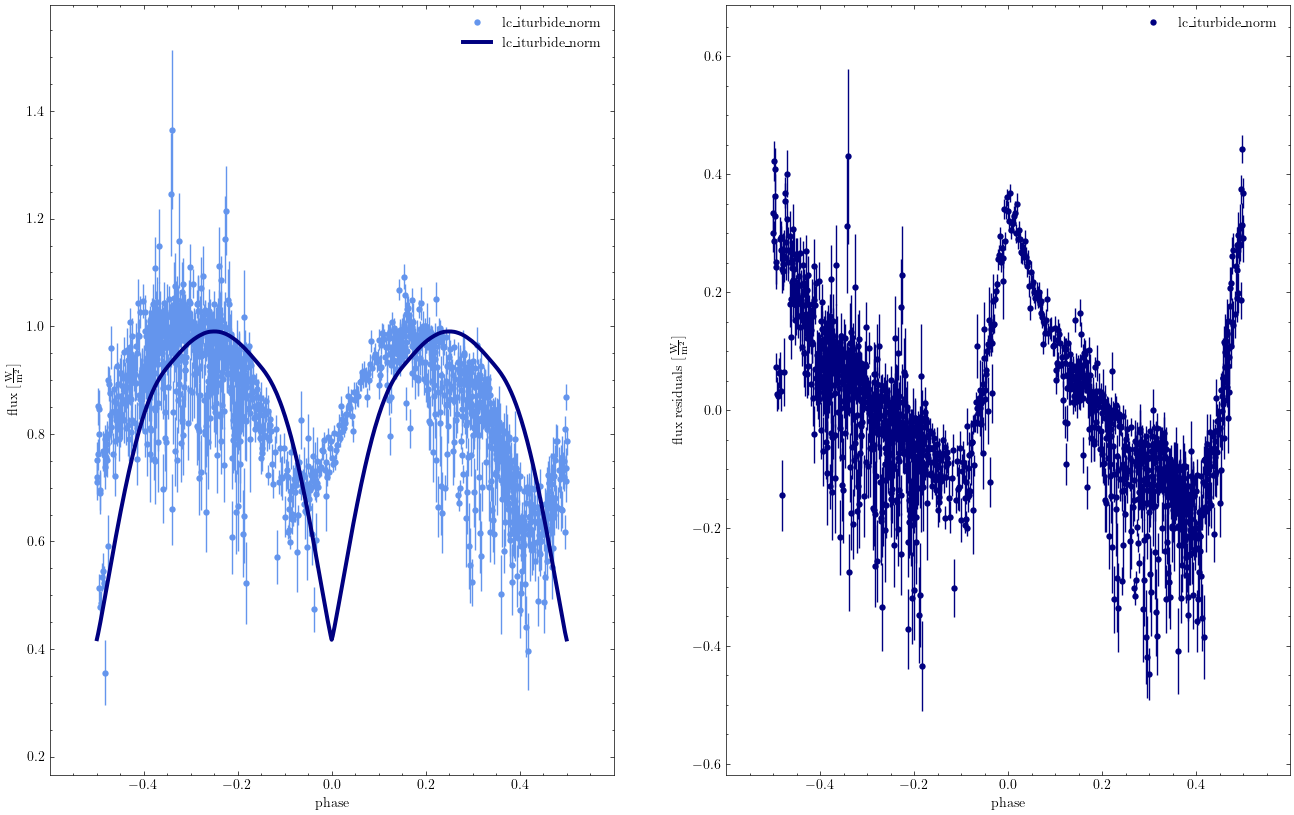

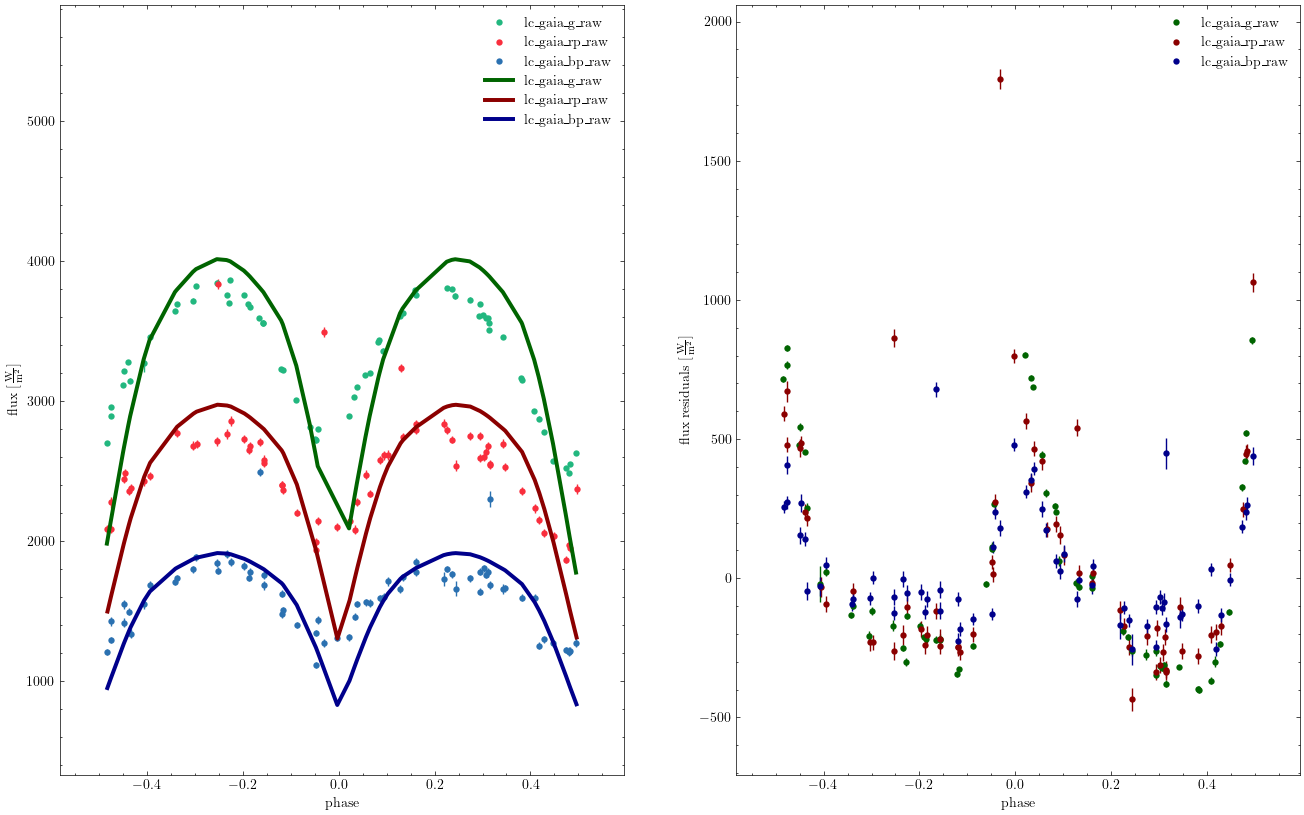

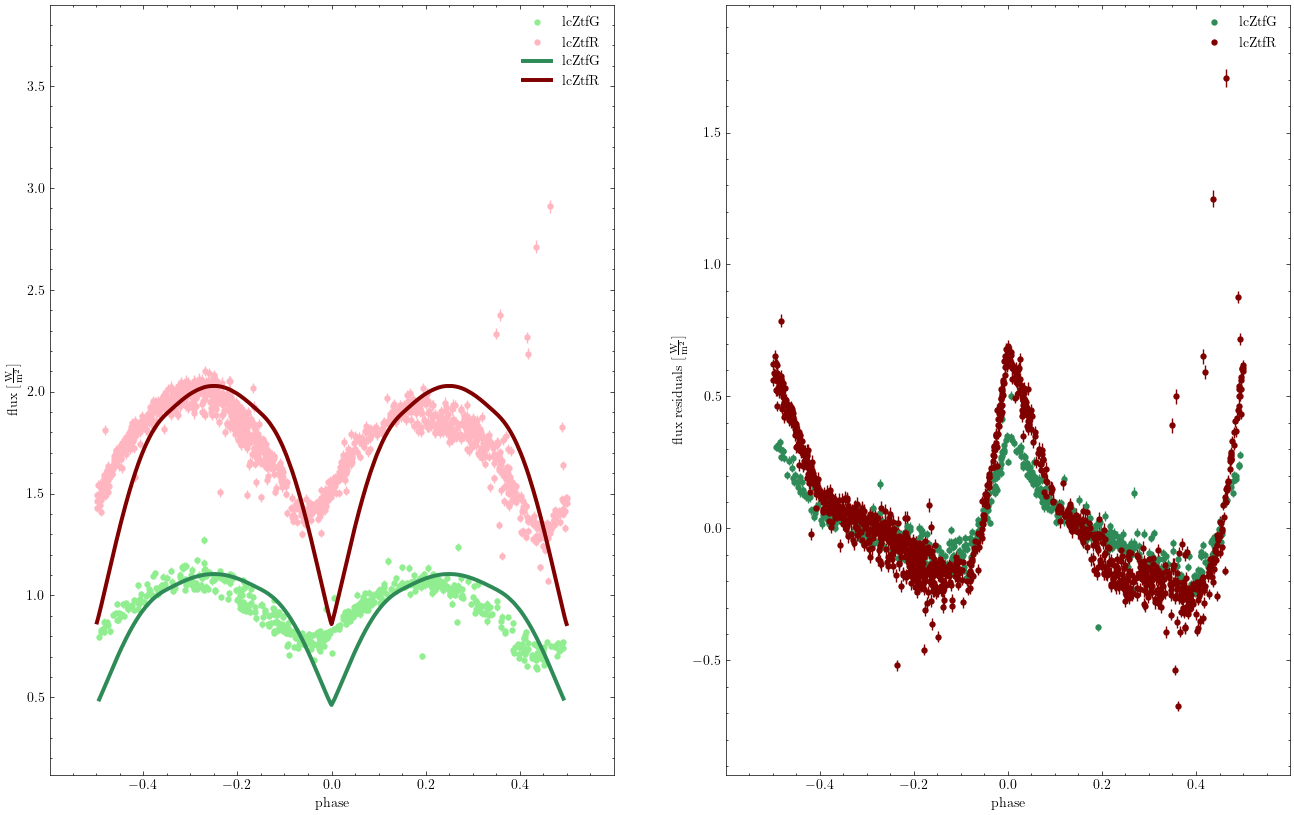

{'lc_iturbide_norm': <Figure size 1600x1000 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x1000 with 2 Axes>,
 'lcZtfG-lcZtfR': <Figure size 1600x1000 with 2 Axes>}

In [22]:
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model='default_model')

# LC Geometry

Should only run if it's detached model

In [23]:
if not IS_CONTACT:
	b.add_solver('estimator.lc_geometry', solver='lcgeom_twogauss', analytical_model='two-gaussian', phase_bin=False, lc_datasets=['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets, overwrite=True)
	b.run_solver(solver='lcgeom_twogauss', solution='lcgeom_twogauss_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'lcgeom_twogauss_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'lcgeom_twogauss_solution')

t0_supconj@binary@orbit@component 2456882.52586 d 
ecc@binary@orbit@component 0.99932  
per0@binary@orbit@component 1.61704 rad 
requivsumfrac@binary@orbit@component 0.00043  
teffratio@binary@orbit@component 0.95328  
mask_phases@binary@lc_iturbide_norm@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lc_gaia_g_raw@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lc_gaia_rp_raw@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lc_gaia_bp_raw@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lcZtfG@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lcZtfR@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.484091231722

In [24]:
if not IS_CONTACT:
	b.add_solver('estimator.lc_geometry', solver='lcgeom_polyfit', analytical_model='polyfit', phase_bin=False, lc_datasets=['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets, overwrite=True)
	b.run_solver(solver='lcgeom_polyfit', solution='lcgeom_polyfit_solution', overwrite=True)
	gen_utils.printFittedVals(b, 'lcgeom_polyfit_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, 'lcgeom_polyfit_solution')

/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/phoebe/dependencies/ligeor/eclipse/eb_params.py:76: UserWarning: Cannot esimate eccentricty and argument of periastron: incomplete geometry information
  warnings.warn('Cannot esimate eccentricty and argument of periastron: incomplete geometry information')


t0_supconj@binary@orbit@component 2456882.52014 d 
ecc@binary@orbit@component 0.00000  
per0@binary@orbit@component 1.57080 rad 
requivsumfrac@binary@orbit@component 0.44526  
teffratio@binary@orbit@component nan  
mask_phases@binary@lc_iturbide_norm@lc@dataset [(0.35864871013202176, 0.5854182721816966), (nan, nan)] 
mask_phases@binary@lc_gaia_g_raw@lc@dataset [(0.35864871013202176, 0.5854182721816966), (nan, nan)] 
mask_phases@binary@lc_gaia_rp_raw@lc@dataset [(0.35864871013202176, 0.5854182721816966), (nan, nan)] 
mask_phases@binary@lc_gaia_bp_raw@lc@dataset [(0.35864871013202176, 0.5854182721816966), (nan, nan)] 
mask_phases@binary@lcZtfG@lc@dataset [(0.35864871013202176, 0.5854182721816966), (nan, nan)] 
mask_phases@binary@lcZtfR@lc@dataset [(0.35864871013202176, 0.5854182721816966), (nan, nan)] 

  t0_supconj@binary@orbit@component -0.03754 d 
  ecc@binary@orbit@component 0.00000 
  per0@binary@orbit@component 0.00000 deg 
C requivsumfrac@binary@orbit@component 0.75973 
C teffrati

# EBAI KNN estimator runs

In [25]:
# ignore sklearn warnings; caused by PHOEBE internals
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ebaiMethod = 'knn' if IS_CONTACT else 'mlp'
ebaiMethod = 'knn'

In [26]:
try:
	b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_all', lc_datasets=['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets, overwrite=True)
	print(b[f'ebai_{ebaiMethod}_all'])

	b.run_solver(solver=f'ebai_{ebaiMethod}_all', solution=f'ebai_{ebaiMethod}_all_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_all_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_all_solution', {'incl@binary@orbit@component': u.rad})
except TypeError as e:
	print(e)

ParameterSet: 7 parameters
     comments@ebai_knn_all@solver: 
   use_server@ebai_knn_all@solver: none
   lc_datasets@ebai_knn_all@so...: ['lc_iturbide_norm', 'lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_all@solver: median
    phase_bin@ebai_knn_all@solver: False
   ebai_method@ebai_knn_all@so...: knn
        orbit@ebai_knn_all@solver: binary


Thu, 06 Jun 2024 01:58 PHOEBE       WARNING checks will not be run until 'run_checks' or 'run_compute' is called.
Thu, 06 Jun 2024 01:58 PHOEBE       WARNING constraints will not be run until 'run_delayed_constraints' or 'run_compute' is called.  This may result in inconsistent parameters if printing values before calling either of these methods.


t0_supconj@binary@orbit@component 0.10179 d 
teffratio@binary@orbit@component 0.93745  
requivsumfrac@binary@orbit@component 0.68696  
esinw@binary@orbit@component -0.00916  
ecosw@binary@orbit@component 0.00961  
incl@binary@orbit@component 1.42729 rad 

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 1.57080 rad 


In [27]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_ztf_gaia', lc_datasets=rawGaiaDatasets + ztfDatasets, overwrite=True)
print(b['ebai_knn_ztf_gaia'])

b.run_solver(solver=f'ebai_{ebaiMethod}_ztf_gaia', solution=f'ebai_{ebaiMethod}_ztf_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_ztf_gaia_solution', units={'incl@binary@orbit@component': u.deg})
print()
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_ztf_gaia_solution', {'incl@binary@orbit@component': u.deg})

ParameterSet: 7 parameters
   comments@ebai_knn_ztf_gaia@...: 
   use_server@ebai_knn_ztf_gai...: none
   lc_datasets@ebai_knn_ztf_ga...: ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_ztf_gai...: median
   phase_bin@ebai_knn_ztf_gaia...: False
   ebai_method@ebai_knn_ztf_ga...: knn
   orbit@ebai_knn_ztf_gaia@solver: binary
t0_supconj@binary@orbit@component 0.08310 d 
teffratio@binary@orbit@component 0.42988  
requivsumfrac@binary@orbit@component 0.42256  
esinw@binary@orbit@component -0.18869  
ecosw@binary@orbit@component -0.11121  
incl@binary@orbit@component 65.65010 deg 

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 90.00000 deg 


In [28]:
try:
	b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_iturbide', lc_datasets=['lc_iturbide_norm'], overwrite=True)
	print(b[f'ebai_{ebaiMethod}_iturbide'])

	b.run_solver(solver=f'ebai_{ebaiMethod}_iturbide', solution=f'ebai_{ebaiMethod}_iturbide_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_iturbide_solution', units={'incl@binary@orbit@component': u.deg})
	print()
	gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_iturbide_solution', {'incl@binary@orbit@component': u.deg})
except TypeError as e:
	print(e)

ParameterSet: 6 parameters
   comments@ebai_knn_iturbide@...: 
   use_server@ebai_knn_iturbid...: none
   lc_datasets@ebai_knn_iturbi...: ['lc_iturbide_norm']
   phase_bin@ebai_knn_iturbide...: False
   ebai_method@ebai_knn_iturbi...: knn
   orbit@ebai_knn_iturbide@solver: binary
t0_supconj@binary@orbit@component -0.05016 d 
teffratio@binary@orbit@component 0.95585  
requivsumfrac@binary@orbit@component 0.68269  
esinw@binary@orbit@component 0.00252  
ecosw@binary@orbit@component -0.00241  
incl@binary@orbit@component 80.52361 deg 

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 90.00000 deg 


In [29]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_iturbide_ztf', lc_datasets=['lc_iturbide_norm'] + ztfDatasets, overwrite=True)
print(b[f'ebai_{ebaiMethod}_iturbide_ztf'])

b.run_solver(solver=f'ebai_{ebaiMethod}_iturbide_ztf', solution=f'ebai_{ebaiMethod}_iturbide_ztf_solution', overwrite=True)
gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_iturbide_ztf_solution')
print()
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_iturbide_ztf_solution', {'incl@binary@orbit@component': u.rad})

ParameterSet: 7 parameters
   comments@ebai_knn_iturbide_...: 
   use_server@ebai_knn_iturbid...: none
   lc_datasets@ebai_knn_iturbi...: ['lc_iturbide_norm', 'lcZtfG', 'lcZtfR']
   lc_combine@ebai_knn_iturbid...: median
   phase_bin@ebai_knn_iturbide...: False
   ebai_method@ebai_knn_iturbi...: knn
   orbit@ebai_knn_iturbide_ztf...: binary
t0_supconj@binary@orbit@component 0.10179 d 
teffratio@binary@orbit@component 0.93745  
requivsumfrac@binary@orbit@component 0.68696  
esinw@binary@orbit@component -0.00916  
ecosw@binary@orbit@component 0.00961  
incl@binary@orbit@component 1.42729 rad 

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 1.57080 rad 


In [30]:
# normalized ZTF datasets

b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_ztf', lc_datasets=ztfDatasets, overwrite=True)
try:
	b.run_solver(solver=f'ebai_{ebaiMethod}_ztf', solution=f'ebai_{ebaiMethod}_ztf_solution', overwrite=True)
	gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_ztf_solution')
	print()
	gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_ztf_solution', {'incl@binary': u.rad})
except TypeError as e:
	print("Failed to generate estimation for normalized Gaia data", e, sep='\n')

t0_supconj@binary@orbit@component 0.08310 d 
teffratio@binary@orbit@component 0.44658  
requivsumfrac@binary@orbit@component 0.42922  
esinw@binary@orbit@component -0.15131  
ecosw@binary@orbit@component -0.07342  
incl@binary@orbit@component 1.14890 rad 

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 90.00000 deg 


In [31]:
b.add_solver('estimator.ebai', ebai_method=ebaiMethod, phase_bin=False, solver=f'ebai_{ebaiMethod}_raw_gaia', lc_datasets=rawGaiaDatasets, overwrite=True)
b.run_solver(solver=f'ebai_{ebaiMethod}_raw_gaia', solution=f'ebai_{ebaiMethod}_raw_gaia_solution', overwrite=True)
gen_utils.printFittedVals(b, f'ebai_{ebaiMethod}_raw_gaia_solution')
print()
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_raw_gaia_solution', {'incl@binary': u.rad})

t0_supconj@binary@orbit@component -0.05356 d 
teffratio@binary@orbit@component 0.94611  
requivsumfrac@binary@orbit@component 0.67469  
esinw@binary@orbit@component 0.00598  
ecosw@binary@orbit@component 0.01545  
incl@binary@orbit@component 1.45659 rad 

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 90.00000 deg 


In [32]:
print(b['teffratio'])
print(b['fillout_factor']) # only appears for contact binary
print(b['teff'])

ParameterSet: 2 parameters
C      teffratio@binary@component: 1.0
             teffratio@constraint: {teff@secondary@component} / {teff@primary@component}
ParameterSet: 0 parameters
NO PARAMETERS
ParameterSet: 3 parameters
           teff@primary@component: 6000.0 K
         teff@secondary@component: 6000.0 K
   teff@poro_porb_bounds@distr...: <distl.uniform low=5663.28797874126 high=5826.3071827964195 unit=K label=teff@primary label_latex=$T_{ \mathrm{ eff }, \mathrm{ primary } }$>


## Testing fit of each solution

### Temporary back up
Storing the original bundle results in memory, in case need to revert arises

In [33]:
backupBundle = b.copy()

In [34]:
%%script echo "skipping; comment this out if we need to reset to previous state"
b = backupBundle.copy()

skipping; comment this out if we need to reset to previous state


In [35]:
b.solutions, b.solvers, b.models

(['lcperiod_iturbide_auto_solution',
  'lcperiod_manual_solution',
  'lcgeom_twogauss_solution',
  'lcgeom_polyfit_solution',
  'ebai_knn_all_solution',
  'ebai_knn_ztf_gaia_solution',
  'ebai_knn_iturbide_solution',
  'ebai_knn_iturbide_ztf_solution',
  'ebai_knn_ztf_solution',
  'ebai_knn_raw_gaia_solution'],
 ['lcperiod_iturbide_auto',
  'lcperiod_manual',
  'lcgeom_twogauss',
  'lcgeom_polyfit',
  'ebai_knn_all',
  'ebai_knn_ztf_gaia',
  'ebai_knn_iturbide',
  'ebai_knn_iturbide_ztf',
  'ebai_knn_ztf',
  'ebai_knn_raw_gaia'],
 ['default_model'])

### Flip constraints

In [36]:
gen_utils.printFittedTwigsConstraints(b, f'ebai_{ebaiMethod}_raw_gaia_solution', {'incl@binary': u.rad})

  t0_supconj@binary@orbit@component -0.03754 d 
C teffratio@binary@orbit@component 1.00000 
C requivsumfrac@binary@orbit@component 0.75973 
C esinw@binary@orbit@component 0.00000 
C ecosw@binary@orbit@component 0.00000 
  incl@binary@orbit@component 90.00000 deg 


In [38]:
b.flip_constraint('teffratio', solve_for='teff@secondary')
if IS_CONTACT:
	b.flip_constraint('pot@contact_envelope', solve_for='requiv@primary')
	b.flip_constraint('fillout_factor', solve_for='pot@contact_envelope')
else:
	b.flip_constraint('sma@binary', solve_for='q')
	b.flip_constraint('requivsumfrac', solve_for='sma@binary')

### Checking solution goodness of fit

In [39]:
b.set_value_all(qualifier='enabled', value=True)

# using only raw datasets right now
# gen_utils.abilitateDatasets(b, allRawDatasets)

print(b['enabled'])

ParameterSet: 7 parameters
   enabled@mesh01@phoebe01@com...: True
   enabled@lc_iturbide_norm@ph...: True
   enabled@lc_gaia_g_raw@phoeb...: True
   enabled@lc_gaia_rp_raw@phoe...: True
   enabled@lc_gaia_bp_raw@phoe...: True
   enabled@lcZtfG@phoebe01@com...: True
   enabled@lcZtfR@phoebe01@com...: True


In [40]:
print(b['requiv'])
print(b['sma@binary'])
print(b['mass'])
print(b['q'])
print(b['ntriangles'])

ParameterSet: 4 parameters
C        requiv@primary@component: 2.0132728169233967 solRad
C      requiv@secondary@component: 2.0132728169233967 solRad
        requiv@primary@constraint: 1.000000 * {requiv_max@primary@component}
      requiv@secondary@constraint: 1.000000 * {requiv_max@secondary@component}
ParameterSet: 2 parameters
C            sma@binary@component: 5.2999937882532775 solRad
            sma@binary@constraint: ({requiv@primary@component} + {requiv@secondary@component}) / {requivsumfrac@binary@component}
ParameterSet: 4 parameters
           mass@primary@component: 8.976728491631974 solMass
C        mass@secondary@component: 8.976728491631972 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683323801509998 high=1.1763674300009999 unit=solMass

In [41]:
if IS_CONTACT:
	b.set_value(qualifier='ntriangles', value=5000) # originally 3000
	print(b['ntriangles'])

In [47]:
print(b['ecc'])
print(b['per0'])

ParameterSet: 2 parameters
C            ecc@binary@component: 0.0
                   ecc@constraint: (({esinw@binary@component} ** 2.000000) + ({ecosw@binary@component} ** 2.000000)) ** 0.500000
ParameterSet: 2 parameters
C           per0@binary@component: 0.0 deg
                  per0@constraint: arctan2({esinw@binary@component}, {ecosw@binary@component})


In [64]:
importlib.reload(gen_utils)
PLOT_MODELS = True
ANIMATE = True
SAVE_BINARY_ANIMATION = True
logger.setLevel('WARNING')

def checkEstimators(solvers: list[str]): 
	for solver in solvers:
		solution = f"{solver}_solution"
		model = f"{solver}_model"
	
		# skipping any failed solvers
		if solution not in b.solutions:
			print("================================================")
			print(f"{solution} not found")
			print("================================================")
			continue
	
		print(solution, "|", model)
		print("------------------------------------------------")
	
		try:
			gen_utils.adopt_solution(b, solution, model_name=model, reset_params=True, run_compute=not model in b.models)
			# gen_utils.adopt_solution(b, solution, model_name=model, reset_params=True, run_compute=True)
		except Exception as e:
			print("=====================================")
			print(f"Failed to adopt {solution}", e, sep='\n')
			print("=====================================")
			b.remove_model(model)
			continue
		
		# printChi2(b, model)
		gen_utils.printChi2(b, model)
	
		if PLOT_MODELS:
			plotDatasetGroups = [['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets]
			gen_utils.plotModelResidualsFigsize(b, figsize=(20, 5), datasetGroups=plotDatasetGroups, model=model)
	
			if ANIMATE:
				gen_utils.displayAnims(1, 3, 
						gen_utils.genAnimatedMesh(b, logger, model=model, draw_title=True, title=model, save=f"./graphs/iturbide-gaia-ztf-final/anims/{solver}.gif" if SAVE_BINARY_ANIMATION else None),
						gen_utils.genAnimatedMesh(b, logger, model=model, component='primary', draw_title=True, title=f"{model} - Primary"),
						gen_utils.genAnimatedMesh(b, logger, model=model, component='secondary', draw_title=True, title=f"{model} - Secondary"))

if len(b.get_parameter(qualifier='ecc', context='component').constrained_by) != 0:
	b.flip_constraint(qualifier='ecc', solve_for='ecosw')
	b.flip_constraint(qualifier='per0', solve_for='esinw')
checkEstimators(['lcgeom_twogauss', 'lcgeom_polyfit'])

# necessary for EBAI estimators
if len(b.get_parameter(qualifier='ecosw', context='component').constrained_by) != 0:
	b.flip_constraint('ecosw', solve_for='ecc')
	b.flip_constraint('esinw', solve_for='per0')
checkEstimators([s for s in b.solvers if f'ebai_{ebaiMethod}' in s])

lcgeom_twogauss_solution | lcgeom_twogauss_model
------------------------------------------------
Adopted:
t0_supconj@binary@orbit@component 2456882.52586 d 
ecc@binary@orbit@component 0.99932  
per0@binary@orbit@component 1.61704 rad 
requivsumfrac@binary@orbit@component 0.00043  
teffratio@binary@orbit@component 0.95328  
mask_phases@binary@lc_iturbide_norm@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lc_gaia_g_raw@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lc_gaia_rp_raw@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lc_gaia_bp_raw@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases@binary@lcZtfG@lc@dataset [(0.29539478218097465, 0.6176254971339394), (-0.4843732354231692, -0.4840912317226705)] 
mask_phases

KeyboardInterrupt: 

<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_125086/15078558.py:39: SyntaxWarning: invalid escape sequence '\l'
  plt.title("EBAI Estimates $\lambda$")


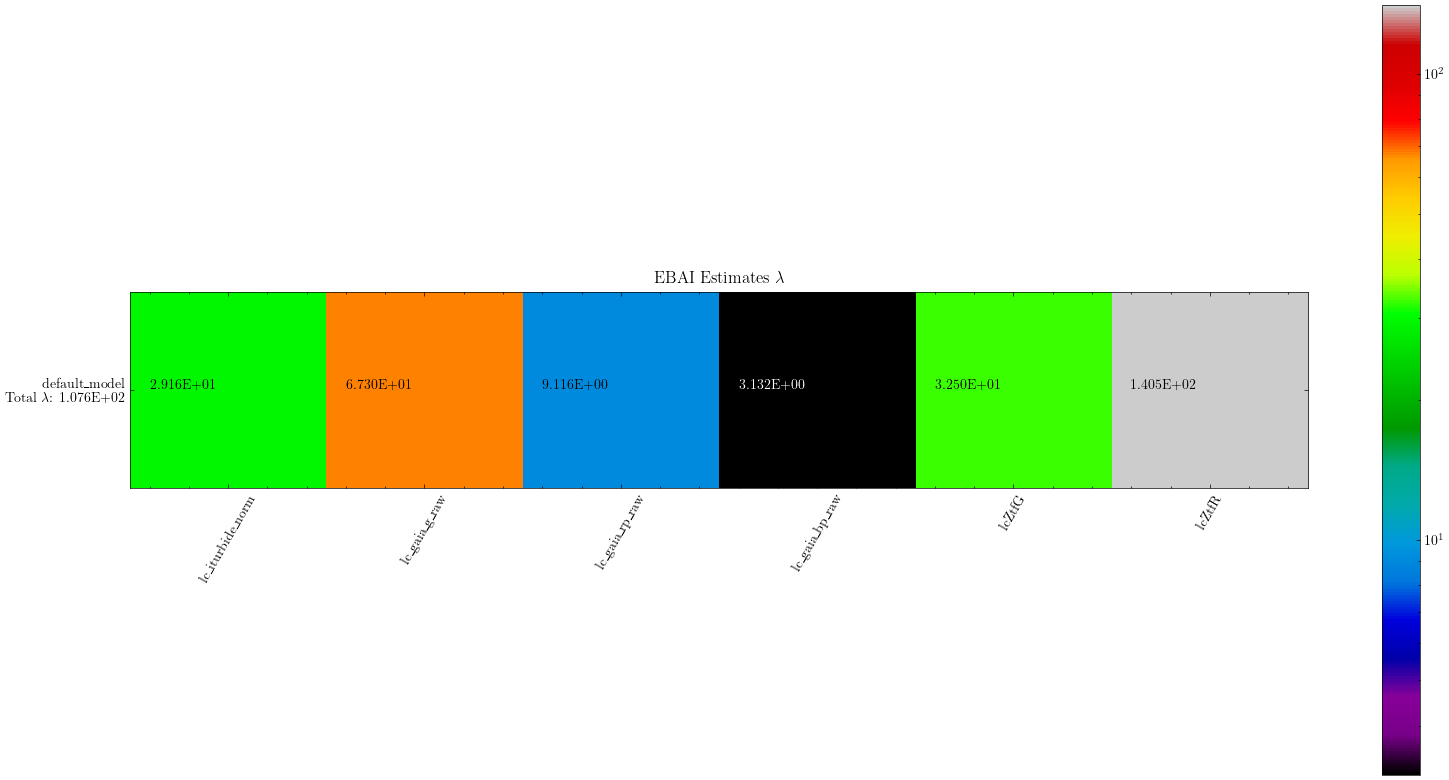

In [44]:
from matplotlib.colors import LogNorm

# ebaiModels = [m for m in b.models if f'ebai_{ebaiMethod}' in m]
comparisonModels = b.models
datasets = [d for d in b.datasets if 'mesh' not in d]
totalNumObservations = 0
for d in datasets:
	totalNumObservations += len(b.get_value(qualifier='times', context='dataset', dataset=d))

modelsDatasetsMatrix = np.zeros(shape=(len(comparisonModels), len(datasets)))
lambdaCostMatrix = np.zeros(shape=(len(comparisonModels), len(datasets)))

for m_idx, model in enumerate(comparisonModels):
	for d_idx, dataset in enumerate(datasets):
		numObservations = len(b.get_value(qualifier='times', context='dataset', dataset=d))
		modelsDatasetsMatrix[m_idx, d_idx] = np.sum(b.calculate_chi2(model=model, dataset=dataset))
		lambdaCostMatrix[m_idx, d_idx] = modelsDatasetsMatrix[m_idx, d_idx] / numObservations # cost normalization from PHOEBE reference ch. 6.1

plt.figure(figsize=(19, 10))
# plt.imshow(modelsDatasetsMatrix, norm=LogNorm(), cmap='nipy_spectral')
plt.imshow(lambdaCostMatrix, norm=LogNorm(), cmap='nipy_spectral')
for m_idx in range(len(comparisonModels)):
	# for d_idx in range(len(datasets)):
	for d_idx, d in enumerate(datasets):
		# chi2 = modelsDatasetsMatrix[m_idx, d_idx]
		lambdaCost = lambdaCostMatrix[m_idx, d_idx]
		# plt.text(d_idx - 0.4, m_idx, '%.3E' % chi2, color='black' if chi2 > 1e4 else 'white')
		plt.text(d_idx - 0.4, m_idx, '%.3E' % lambdaCost, color='black' if lambdaCost > 4 else 'white')
		# plt.text(d_idx - 0.4, m_idx, '%.3E' % lambdaCost, color='black')

plt.xticks(np.arange(len(datasets), dtype=int), datasets, rotation=60)

yticks = []
for m_idx, model in enumerate(comparisonModels):
	# yticks.append(f"{model}\nTotal $\\chi^2$: %.3E" % np.sum(modelsDatasetsMatrix[m_idx, :]))
	yticks.append(f"{model}\nTotal $\\lambda$: %.3E" % (np.sum(modelsDatasetsMatrix[m_idx, :])/totalNumObservations))
plt.yticks(np.arange(len(comparisonModels), dtype=int), yticks)
# plt.title("EBAI Estimates $\chi^2$")
plt.title("EBAI Estimates $\lambda$")
plt.colorbar()

In [ ]:
for s in b.solutions:
	if f'ebai_{ebaiMethod}' in s:
		print(s, "-------------------------", sep='\n')
		gen_utils.printFittedVals(b, s)
		print("Datasets:", b[f'value@{s.replace("_solution", "").replace("_norm", "")}@lc_datasets'])
		print()

In [67]:
gen_utils.printFittedVals(b, solution=f'ebai_{ebaiMethod}_raw_gaia_solution', units={'incl@binary@orbit@component': u.deg})
print()
gen_utils.printFittedTwigsConstraints(b, solution=f'ebai_{ebaiMethod}_raw_gaia_solution', units={'incl@binary@orbit@component': u.deg})

t0_supconj@binary@orbit@component -0.05356 d 
teffratio@binary@orbit@component 0.98573  
incl@binary@orbit@component 71.07442 deg 
fillout_factor@contact_envelope@envelope@component 0.18522  
q@binary@orbit@component 1.85648  

  t0_supconj@binary@orbit@component -0.03754 d 
  teffratio@binary@orbit@component 1.00000 
  incl@binary@orbit@component 90.00000 deg 
  fillout_factor@contact_envelope@envelope@component 0.64179 
  q@binary@orbit@component 1.00000 


In [71]:
b.adopt_solution(f'ebai_{ebaiMethod}_raw_gaia_solution')
# b.adopt_solution(chosenSolution)

<ParameterSet: 38 parameters | contexts: component, dataset>

# Save estimator bundle

In [72]:
# gen_utils.saveBundle(b, "ebai-estimates")
# gen_utils.saveBundle(b, "ebai-estimates", "comp-LID3")
# gen_utils.saveBundle(b, "ebai-solver-runs-no-estimates")
# gen_utils.saveBundle(b, bundleName="ebai-estimates", subfolder="aviles-iturbide-gaia-ztf-relative_norm")
gen_utils.saveBundle(b, bundleName="ebai-estimates", subfolder="clean-iturbide-gaia-ztf")

'bundle-saves/clean-iturbide-gaia-ztf/ebai-estimates'

# Trimming Bundle

Dropping unused datasets, as well as cleaning up models that won't be used in future steps

In [73]:
# removing unused models (all of them until now)
b.remove_model(b.models)

<ParameterSet: 1098 parameters | contexts: figure, model>

In [74]:
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed')
# gen_utils.saveBundle(b, 'ebai-estimates-trimmed', "comp-LID3")
gen_utils.saveBundle(b, bundleName="ebai-estimates-trimmed", subfolder="clean-iturbide-gaia-ztf")

'bundle-saves/clean-iturbide-gaia-ztf/ebai-estimates-trimmed'